# 【課題】量子カーネルを使った新現象の分類

これまで、量子・古典ハイブリッドアルゴリズムの一つである{doc}`量子回路学習 <vqc_machine_learning>`の手法を使って、素粒子物理での新粒子探索が可能かを見てきました。ここでは、**量子機械学習**の別の手法として、**量子カーネル**を用いた分類を考えてみます。特に、量子カーネルを活用した**サポートベクターマシン**の手法{cite}`quantum_svm`を使って、同じ新粒子探索の問題に取り組みます。

```{contents} 目次
---
local: true
---
```

$\newcommand{\ket}[1]{| #1 \rangle}$
$\newcommand{\expval}[3]{\langle #1 | #2 | #3 \rangle}$

(q_kernel)=
## 量子カーネル

変分量子回路を使った量子回路学習では、

$$
U_{\text{in}}(x_i) = \prod_j R_j^Z(\cos^{-1}(x^2))R_j^Y(\sin^{-1}(x))
$$

と定義した特徴量マップ$U_{\text{in}}(x_i)$を考えました。それを初期状態$\ket{0}^{\otimes n}$に適用することで、入力データから$\ket{\phi(x_i)}=U_{\text{in}}(x_i)\ket{0}^{\otimes n}$という量子状態を作りました。**量子カーネル**とは、この状態の内積$\langle\phi^\dagger(x_j)|\phi(x_i)\rangle$（の絶対値2乗）

$$
K(x_i,x_j):=|\langle\phi^\dagger(x_j)|\phi(x_i)\rangle|^2=|\langle0^{\otimes n}|U_{\text{in}}^\dagger(x_j)U_{\text{in}}(x_i)|0^{\otimes n}\rangle|^2
$$

として定義される量です。量子カーネルの物理的な意味ですが、内積というものが表す通り、$\ket{\phi(x_i)}$と$\ket{\phi(x_j)}$の「近さ」あるいは「重なり具合」を表していると解釈できます。

(q_kernel_imp)=
### 量子カーネルの評価

量子カーネルを求めるためには、学習データの全てのペア$\{x_i,x_j\}$に対して、$K(x_i,x_j)=|\langle\phi^\dagger(x_j)|\phi(x_i)\rangle|^2$を計算する必要があります。ここで「カーネルトリック」という言葉がよく使われますが、ヒルベルト空間での座標変数に明示的に依存しない形で$K(x_i,x_j)$を計算するために、以下のような量子回路を考えます。

```{image} figs/qke_circuit.png
:alt: qke_circuit
:class: bg-primary mb-1
:width: 700px
:align: center
```

この回路に入力データ$x_i$と$x_j$をエンコードして、回路の出力状態を$Z$基底で測定するとします。カーネルの定義式から明らかなように、その時に全ての量子ビットが0になる（$0^n$ビット列が出てくる）確率が$K(x_i,x_j)$の評価値を与えてくれます。これを全てのペアに対して繰り返し実行し、カーネル行列の要素を決めていくことになるわけです。$0^n$ビット列測定によってカーネルを決めるため、量子回路の測定回数$N$に対して$\cal{O}(1/\sqrt{N})$程度の誤差がついてしまうのは仕方ないところです。


(svm)=
### サポートベクターマシン

上までのステップでカーネル行列が得られましたが、次にこのカーネル行列をサポートベクターマシンと呼ばれる手法に取り入れて、データ分類を行なってみます。

まず、線形サポートベクターマシンとはどういうものかを見ていきます。2クラス分類を考えるとして、$+1$と$-1$を持つクラス$C=\{+1,-1\}$とします。学習データを$\{(\boldsymbol{x}_i,y_i)\}\:(i=1,\ldots,N)$とすると、$y_i\in\{+1,-1\}$です。$i$は各データを表すインデックス、$\boldsymbol{x}_i$は$d$次元の実数変数$\boldsymbol{x}_i\in\mathbb{R}^d$としておきます。

サポートベクターによる線形分離とは、ある空間にデータ点の集合が分布しているとして、それを超平面（Hyperplane）で二つの領域に分離するという問題です。超平面とは、$\boldsymbol{w}\in\mathbb{R}^d$をデータと同じ次元数の実数ベクトルとして、$\boldsymbol{w}\circ\boldsymbol{x}+b=0$を満たす$(\boldsymbol{w},b)$のことを超平面と読んでいます。$b$はバイアス、$\circ$は内積を表していて、$\boldsymbol{w}$は超平面に直交するベクトルと考えることができます。データの線形分離は、

$$
y_i(\boldsymbol{w}\circ\boldsymbol{x}_i+b)\geq1,\:\:\:\forall i=1,\ldots,N
$$

を満たす$(\boldsymbol{w},b)$を見つけることができれば、$2/||\boldsymbol{w}||$のマージン（超平面からデータ点までの距離）を持って分離できることが知られています。このような超平面が見つかれば、新しいテストデータ$\boldsymbol{x'}\in\mathbb{R}^d$に対して$\boldsymbol{w}\circ\boldsymbol{x'}+b$の符号（超平面で分離される領域のどちらにデータが分布しているか）を見ることで、分離ができるという仕組みです。


(qsvm)=
### 量子サポートベクター

量子サポートベクターマシンは、ヒルベルト空間にエンコードされた特徴量空間で、このデータ分離を行います。上の式では、マージンが$2/||\boldsymbol{w}||$なので、$||\boldsymbol{w}||$を最小化することでマージンが大きな超平面を探すことが考えられます。特徴量空間での超平面探索では、非線形変換が可能な特徴量マップが関わってくるため、少し違う形ですが同等なものとして以下の距離に相当する量$L$

$$
L(\boldsymbol{\alpha})=\sum_{i=1}^N\alpha_i-\frac12\sum_{i,j=1}^Ny_iy_j\alpha_i\alpha_jK(\boldsymbol{x}_i,\boldsymbol{x}_j)
$$

を考えます。この$L$が最大になるパラメータ$\boldsymbol{\alpha}=\{\alpha_i\}\:(i=1,\ldots,N)$を見つける問題になるのですが、$\alpha_i$は以下の条件を満たす必要があります。

$$
\sum_{i=1}^N\alpha_iy_i=0,\:\:\:\alpha_i\geq0
$$

最適化によって、$L$を最大化するパラメータ$\boldsymbol{\alpha}^*=\{\alpha_1^*,\ldots,\alpha_N^*\}$が見つかったとします。その最適パラメータと学習データで求めたカーネル行列を使うことで、新しいデータ$\boldsymbol{x'}$に対して$\sum_{i=1}^Ny_i\alpha_i^*K(\boldsymbol{x}_i,\boldsymbol{x'})+b^*$の符号を調べることで、クラス分類が可能になるというわけです。最適なバイアス$b^*$は$\sum_{j=1}^Ny_j\alpha_j^*K(\boldsymbol{x}_j,\boldsymbol{x}_i)+b=y_i$を解くことによって、最適パラメータ$\boldsymbol{\alpha}^*$と学習データから求めることができます。


(qsvm_imp)=
## 素粒子探索への応用

それでは、{doc}`ここ <vqc_machine_learning>`で考えた素粒子現象の探索問題に、量子サポートベクターマシンを応用してみましょう。

データセットの準備は同じです。

In [1]:
# Tested with python 3.8.12, qiskit 0.34.2, numpy 1.22.2
# General imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# scikit-learn imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Qiskit imports
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit_machine_learning.kernels import QuantumKernel

In [15]:
# ファイルから変数を読み出す
df = pd.read_csv("data/SUSY_1K.csv",
                 names=('isSignal','lep1_pt','lep1_eta','lep1_phi','lep2_pt','lep2_eta',
                        'lep2_phi','miss_ene','miss_phi','MET_rel','axial_MET','M_R','M_TR_2',
                        'R','MT2','S_R','M_Delta_R','dPhi_r_b','cos_theta_r1'))

# 学習に使う変数の数
feature_dim = 3  # dimension of each data point

# 3, 5, 7変数の場合に使う変数のセット
if feature_dim == 3:
    SelectedFeatures = ['lep1_pt', 'lep2_pt', 'miss_ene']
elif feature_dim == 5:
    SelectedFeatures = ['lep1_pt','lep2_pt','miss_ene','M_TR_2','M_Delta_R']
elif feature_dim == 7:
    SelectedFeatures = ['lep1_pt','lep1_eta','lep2_pt','lep2_eta','miss_ene','M_TR_2','M_Delta_R']

# 学習に使う事象数: trainingは訓練用サンプル、testingはテスト用サンプル
train_size = 20
test_size = 20

# オプティマイザーをCallする回数の上限
niter = 300
random_seed = 10598

df_sig = df.loc[df.isSignal==1, SelectedFeatures]
df_bkg = df.loc[df.isSignal==0, SelectedFeatures]

# サンプルの生成
df_sig_train = df_sig.values[:train_size]
df_bkg_train = df_bkg.values[:train_size]
df_sig_test = df_sig.values[train_size:train_size+test_size]
df_bkg_test = df_bkg.values[train_size:train_size+test_size]
train_data = np.concatenate([df_sig_train,df_bkg_train])
test_data = np.concatenate([df_sig_test,df_bkg_test])
#print('train_data =',training_data)
#print('test_data =',test_data)
train_label = np.concatenate([np.ones((train_size),dtype=int),np.zeros((train_size),dtype=int)])
test_label = np.concatenate([np.ones((test_size),dtype=int),np.zeros((test_size),dtype=int)])

train_label_one_hot = np.zeros((train_size*2, 2))
for i in range(train_size*2):
    train_label_one_hot[i, train_label[i]] = 1
test_label_one_hot = np.zeros((test_size*2, 2))
for i in range(test_size*2):
    test_label_one_hot[i, test_label[i]] = 1

mms = MinMaxScaler((-1, 1))
norm_train_data = mms.fit_transform(train_data)
norm_test_data = mms.transform(test_data)

(problem1)=
#### 問題1

各自特徴量マップを選び、実装してください。

In [16]:
##################
### EDIT BELOW ###
##################

feature_map = ...

##################
### EDIT ABOVE ###
##################

(problem2)=
#### 問題2

最初の二つのデータ$x_0=$norm_train_data[0]と$x_1=$norm_train_data[1]に対するカーネル行列要素を計算するための量子回路を作ってください。

In [ ]:
##################
### EDIT BELOW ###
##################

qc_circuit = ...

##################
### EDIT ABOVE ###
##################

作った量子回路をシミュレータで実行して、全ての量子ビットで0を測定する確率を調べてください。

In [ ]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc_circuit,
              backend,
              shots=8192,
              seed_simulator=random_seed,
              seed_transpiler=random_seed)

counts = job.result().get_counts(qc_circuit)
print(f"Probability of observing 0^n state = {counts['0'*feature_dim]/sum(counts.values())}")

Qiskitには特徴量マップから量子カーネルを作ってくれるAPIが準備されていて、それを使えば課題2は実は簡単に実行できます。

In [ ]:
q_kernel = QuantumKernel(feature_map=feature_map, quantum_instance=Aer.get_backend('statevector_simulator'))

qc_circuit = q_kernel.construct_circuit(norm_train_data[0], norm_train_data[1])
qc_circuit.decompose().decompose().draw('mpl')

QuantumKernelを使うと、カーネル行列を直接書き出して見ることも容易にできます。学習データから求めたカーネル行列と、学習データとテストデータから計算したカーネル行列をプロットしてみます。

Transition amplitude: 0.095947265625


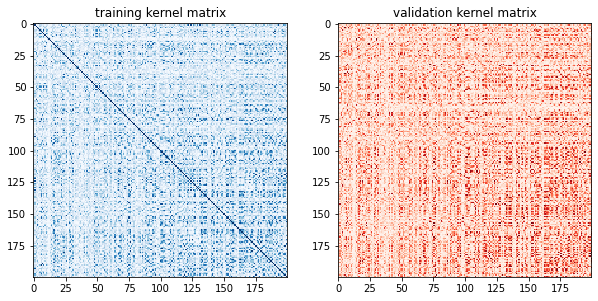

In [19]:
matrix_train = q_kernel.evaluate(x_vec=norm_train_data)
matrix_test = q_kernel.evaluate(x_vec=norm_test_data, y_vec=norm_train_data)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_train), interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_test), interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("validation kernel matrix")
plt.show()

In [ ]:
最後に、sklearnパッケージに実装されているサポートベクターマシンを使って分類を行います。量子回路学習の場合と同様に、データサイズや特徴量マップを変えるなどして分類精度がどう変わるかなど、調べてみてください。

In [20]:
qc_svc = SVC(kernel='precomputed')
qc_svc.fit(matrix_train, train_label)

train_score = qc_svc.score(matrix_train, train_label)
test_score = qc_svc.score(matrix_test, test_label)

print(f'Precomputed kernel: Classification Train score: {train_score*100}%')
print(f'Precomputed kernel: Classification Test score:  {test_score*100}%')

Precomputed kernel: Classification Train score: 77.0%
Precomputed kernel: Classification Test score:  73.5%


**提出するもの**
- 選んだ特徴量マップの説明とその量子回路
- カーネル行列要素を計算するための量子回路
- サポートベクターマシンを使った分類結果に対する考察